In [1]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm, metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import plotly.graph_objs as go
import plotly.io as pio
from mlxtend.plotting import plot_decision_regions
import graphviz
from sklearn.tree import export_graphviz

f = '/Users/shenchingfeng/Documents/1112/機器學習/Homework 2/all.csv'

df = pd.read_csv(f)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) ## Red wine == 1 ; White wine == 0

result = pd.DataFrame(columns = ["model", "accuracy"])

select_col = df.drop('wine', axis = 1).columns
for i in select_col:
    df[i], lambda_value = stats.yeojohnson(df[i])

# Cross Validation

### 10-Fold CV

In [2]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

### Grid Search CV

In [3]:
model = svm.SVC()

X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

params = {
    'C': np.logspace(-3, 3, num = 7, base = 10),
    'kernel': ['rbf', 'sigmoid'],
    'gamma': np.logspace(-3, 3, num = 7, base = 10),  
}

grid_search = GridSearchCV(model, param_grid = params, cv = kf)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

result = result.append({'model': 'SVC', 'accuracy': round(grid_search.best_score_, 4)}, ignore_index = True)

Best parameters: {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Best score: 0.9798383311603651


/var/folders/56/1hl93h654354jd5vh2zjmd640000gn/T/ipykernel_31773/2577171853.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'model': 'SVC', 'accuracy': round(grid_search.best_score_, 4)}, ignore_index = True)


# Feature Selection

## Stepwise Selection

In [8]:
X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

In [9]:
from sklearn.svm import SVC

for i in range(X.shape[1]):
    sfs = SFS(
    cv = kf, 
    estimator = SVC(C = 1000, gamma = 'auto', kernel = 'rbf', probability = True, cache_size = 2000),
    forward = True,
    floating = False,
    k_features = i+1, 
    scoring ='f1',
    n_jobs = -1
)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)
    print(sfs.k_score_)
    print("=======================================")

None
None



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [5]:
sfs = SFS(
    cv = kf, 
    estimator = SVC(C = 1000, gamma = 0.01, kernel = 'rbf', probability = True, 
                    cache_size = 2000, shrinking = False, max_iter = int(1e7)),
    forward = True,
    floating = False,
    k_features = X.shape[1], 
    scoring ='f1',
    n_jobs = -1
)
sfs.fit(X, y)

print(sfs.k_feature_names_)
print(sfs.k_score_)

None
None



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [8]:
metric_dict = sfs.get_metric_dict()
k_features = list(metric_dict.keys())
avg_scores = np.array([metric_dict[k]['avg_score'] for k in k_features])
std_devs = np.array([metric_dict[k]['std_dev'] for k in k_features])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x = k_features, y = avg_scores, 
    mode = 'lines+markers', name = 'Average Score'
    )
)

fig.update_layout(
    title = {
        'text': 'Stepwise Selection',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    }, 
    xaxis_title = {
        'text': 'Number of Features',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Performence (F1)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    width = 1200, height = 800
)

fig.show()

AttributeError: SequentialFeatureSelector has not been fitted, yet.

## Lasso

In [ ]:
X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

from sklearn.linear_model import Lasso
lasso = Lasso()
params = {
    'alpha': [10**i for i in range(-10, 11)],
    'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid = params, cv = kf, n_jobs = -1)
gridlasso.fit(X, y)

print("Best alpha:", gridlasso.best_params_)
print("Best scores:", gridlasso.best_score_)

coefficients = gridlasso.best_estimator_.coef_
importance = np.abs(coefficients)
print(np.array(X.columns)[importance > 1])
print(importance)

Best alpha: {'alpha': 1e-08, 'selection': 'random'}
Best scores: 0.8312860264728428
['fixed acidity' 'volatile acidity' 'chlorides' 'pH' 'sulphates' 'alcohol']
[1.94012268e+01 3.13999017e+00 1.15308809e-01 1.18270863e-02
 2.08427751e+01 1.89202679e-02 7.04227274e-03 0.00000000e+00
 4.42252089e+01 2.38130996e+00 1.87684773e+01 2.36408251e-02]


In [ ]:
best_lasso = gridlasso.best_estimator_

alphas = np.array(gridlasso.cv_results_['param_alpha'].data, dtype = 'float')
coefs = gridlasso.cv_results_['mean_test_score']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = np.log10(alphas), y = coefs, 
    mode = 'lines+markers'
    )
)

fig.update_layout(
    title = {
        'text': 'Lasso coefficients as a function of Log alpha',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 
        'x': 0.5
    }, 
    width = 1200, height = 800,
    xaxis_title = {
        'text': 'Log(alpha)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Coefficient',
        'font': {'size': 24, 'family': 'Gulliver'}
    }, 
)

fig.show()

## Feature Group

In [4]:
Stepwise = ['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates']
Lasso =  ['fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']

feature = []

for i in df.drop('wine', axis = 1).columns:
    for i in Stepwise:
        if i not in feature:
            feature.append(i)
        else:
            continue
    for i in Lasso:
        if i not in feature:
            feature.append(i)
        else:
            continue
print(feature)

['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']


# Model

In [5]:
X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

clf = SVC(C = 1000, kernel = 'rbf', gamma = 0.01, probability = True)
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

## Model Performance

[11/11] features ████████████████████ Time elapsed: 0 seconds

Text(0.5, 1.0, 'Feature Importance of SVC')

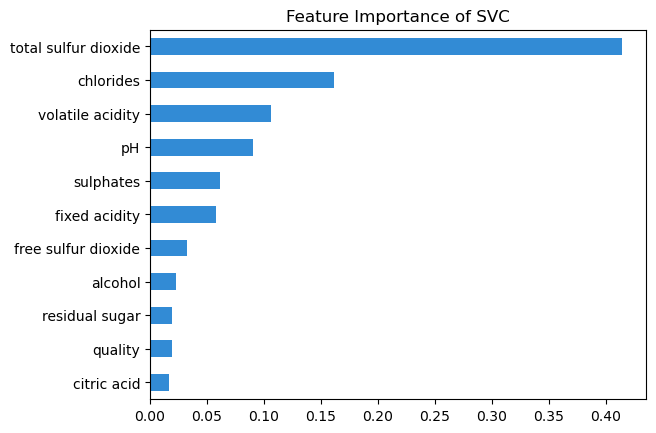

In [6]:
interpreter = Interpretation(
    x_test, feature_names = X.columns
)

pyint_model = InMemoryModel(
    model.predict_proba,
    examples = x_train
)

plots= interpreter.feature_importance.plot_feature_importance(pyint_model, ascending = False, progressbar = True)
plt.title('Feature Importance of SVC')

## Decision Region

In [7]:
feature_name = 'total sulfur dioxide'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)
feature_name = 'chlorides'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)

6
4


### With mlxtend.plotting plot_decision_regions()

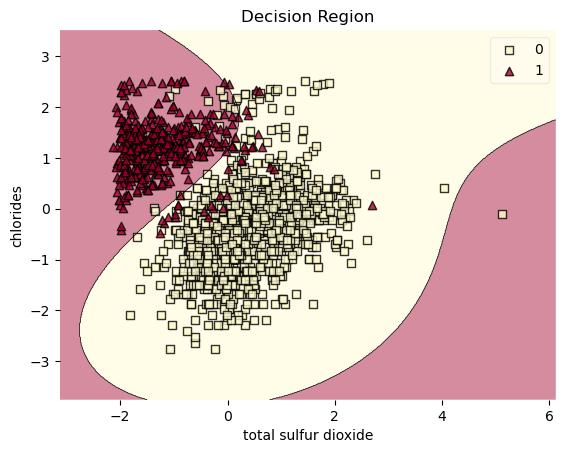

In [8]:
plot_decision_regions(
    x_test[:, [6, 4]], 
    y_test.values, 
    clf = SVC(C = 1000, kernel = 'rbf', gamma = 0.01).fit(x_train[:, [6, 4]], y_train.values),
    colors = '#fffacd,#a00028'
)

plt.title('Decision Region')
plt.xlabel('total sulfur dioxide')
plt.ylabel('chlorides')
plt.show()

### With Scatter plot of Plotly

In [ ]:
trace = go.Scatter(
    x = x_test[:, 1],
    y = x_test[:, 6],
    mode = 'markers',
    marker = dict(
        color = y_pred,
        symbol = y_pred,
        size = 8,
        opacity = 0.9,
        colorscale = [[0, '#fffacd'], [1, '#a00028']],
        line = dict(color = '#444444', width = 0.5)
    )
)

layout = go.Layout(
    title = {
        'text': 'Decision Region',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    },
    xaxis = dict(
        title = {
            'text': 'volatile acidity', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    yaxis = dict(
        title = {
            'text': 'total sulfur dioxide', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    margin = dict(l = 50, r = 50, t = 80, b = 50),
    hovermode = 'closest', 
    width = 800, height = 800,
    showlegend = False,
    template = 'ggplot2'
)

fig = go.Figure(
    data = [trace], 
    layout = layout
)

pio.show(fig)

## Confusion Matrix

In [9]:
acu = metrics.accuracy_score(y_test, y_pred)
pre_class, r_class, f_class, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average = 'weighted')

print("Acurracy: ", round(acu * 100, 4), '%')
print('Precision:', round(pre_class * 100, 4), '%')
print('Recall:', round(r_class * 100, 4), '%')
print('f1:', round(f_class * 100, 4), '%')

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_norm = pd.DataFrame(cm_norm)
cm_norm

Acurracy:  99.5077 %
Precision: 99.5074 %
Recall: 99.5077 %
f1: 99.5073 %


,0,1
0,0.997481,0.002519
1,0.011521,0.988479


## Receiver Operating Characteristic Curve

In [10]:
fpr, tpr, _ = roc_curve(
    y_test, 
    model.predict_proba(x_test)[:, 1]
)

roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(
    x = fpr, y = tpr, 
    mode = 'lines', 
    line = dict(width = 2),
)

trace2 = go.Scatter(
        x = [0, 1], y = [0, 1],
        mode = 'lines',
        line = dict(color = 'navy', width = 2, dash = 'dash'),
        showlegend = False
)

layout = go.Layout(
        title = {
            'text': 'ROC Curves (AUC = {:0.2f})'.format(roc_auc),
            'font': {
                'size': 40, 'family': 'Gulliver'
            }, 
            'x': 0.5, 'y': 0.95
        },
        xaxis = dict(
            title = {
                'text': 'False Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        yaxis = dict(
            title = {
                'text': 'True Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        width = 1200, height = 800,
        showlegend = False
)

fig = go.Figure(
    data = [trace1, trace2], 
    layout = layout
)

fig.show()

# Model Compexity

In [ ]:
C_range = np.logspace(-3, 3, num = 7, base = 10)
gamma_range = np.logspace(-3, 3, num = 7, base = 10)

train_errors = np.zeros((len(C_range), len(gamma_range)))
test_errors = np.zeros((len(C_range), len(gamma_range)))

for i, C in enumerate(C_range):
    for j, gamma in enumerate(gamma_range):
        svm = SVC(C = C, gamma = gamma)
        svm.fit(x_train, y_train)
        train_pred = svm.predict(x_train)
        test_pred = svm.predict(x_test)
        train_errors[i, j] = 1 - accuracy_score(y_train, train_pred)
        test_errors[i, j] = 1 - accuracy_score(y_test, test_pred)

C, gamma = np.meshgrid(C_range, gamma_range)

fig = go.Figure(
    data = [go.Surface(
                x = C, y = gamma, z = train_errors.T, 
                colorscale = 'Blues', opacity = 0.8, name = 'Train Error'
            ),
            go.Surface(
                x = C, y = gamma, z = test_errors.T, 
                colorscale  ='Reds', opacity = 0.8, name = 'Test Error'
                )
            ],
            layout = go.Layout(
                title = {
                    'text': 'Model Complexity for SVC',
                    'font': {
                        'size': 32, 'family': 'Gulliver'
                    }, 
                    'x': 0.5
                },
                scene = dict(
                        xaxis = dict(title = 'C', type = 'log'),
                        yaxis = dict(title = 'Gamma', type = 'log'),
                        zaxis = dict(title = 'Error', type = 'linear'),
                        aspectratio = dict(x = 1, y = 1, z = 0.5),
                        camera = dict(eye = dict(x = -1.5, y = -1.5, z = 0.5)),
                        ),
                margin = dict(l = 0, r = 0, b = 0, t = 80),
                legend = dict(x = 0, y = 1, bgcolor = 'rgba(255, 255, 255, 0.5)'),
            )
)

fig.show()